# Supporting Information

The following section provides specific examples of generative BigSMILES to demonstrate how various polymer ensembles might be created. This is an interactive Jupyter notebook that generates visual representations of polymeric ensembles automatically using the [reference implementation](https://github.com/InnocentBug/bigSMILESgen) of generative BigSMILES. Visual representations of polymers can become complex for long-chain molecules, hence we typically restrict ourselves to a manageable length.

## Preliminary Code for Visualization

This section includes Python code that converts generative BigSMILES into visual representations suitable for a Jupyter notebook. While not essential for understanding the main text, it can serve as a reference for how to use the reference implementation.

In [1]:
import numpy as np
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
import pydot

from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

import bigsmiles_gen
from bigsmiles_gen import System, mol_prob, Molecule, System

# Consistent random numbers also across calls
rng = np.random.default_rng(42)


def render_svg(svg):
    """Render SVG images in the Notebook"""
    try:
        svg_string = svg.decode("utf-8")
    except AttributeError:
        svg_string = svg
    svg_string = svg_string.replace("svg:", "")
    return SVG(svg_string)


def moltosvg(mol, molSize=(450, 150), kekulize=True):
    """Generate a SVG stick representation of molecule."""
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0], molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg


def draw_molecule(molecule_string):
    global rng
    # Generate the abstract python object, parsing bigSMILES
    # Try it as a system first
    bigSMILESmol = System(molecule_string)
    mol = bigSMILESmol.generate(rng=rng)
    return render_svg(moltosvg(mol.mol))


def draw_generation_graph(molecule_string):
    bigSMILESmol = Molecule(molecule_string)
    graph = bigSMILESmol.gen_reaction_graph()
    try: # Does not work with some pydot implementations and new python version, ignore errors then
        graph_dot = bigsmiles_gen.reaction_graph_to_dot_string(graph, bigSMILESmol)
        pydot_graph = pydot.graph_from_dot_data(graph_dot)[0]
        graph_svg = pydot_graph.create_svg()
        return render_svg(graph_svg)
    except AttributeError:
        return None

## Case Study: PS and PMMA

Polystyrene (PS) and polymethyl methacrylate (PMMA) are two well-known and widely studied polymers. We'll use them as examples to demonstrate different concepts of how generative BigSMILES can be employed to create various ensembles.

To begin with, let's consider the standard BigSMILES notation for PS and PMMA repeat units:
`CCOC(=O)C(C)(C){[>][<]CC([>])c1ccccc1[<], [>][<]CC([>])C(=O)OC [<]}[Br]`

In common terms, this represents the random copolymer PS-r-PMMA. Technically, this BigSMILES notation covers all subsequent examples, and we'll show how generative BigSMILES can be used to distinguish between different polymer ensembles.

## PS-r-PMMA with Molecular Weight Distribution

Our first step is to specify the molecular weight distribution. We'll use the Schulz-Zimm distribution as an example, with a molecular weight average (Mw) of 1500 and a number average molecular weight (Mn) of 1400.

In [2]:
# Define a generative bigSMILES string representing an ensemble of molecules
generative_bigSMILES = "CCOC(=O)C(C)(C){[>][<]CC([>])c1ccccc1, [<]CC([>])C(=O)OC [<]}|schulz_zimm(1500, 1400)|[Br]"

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


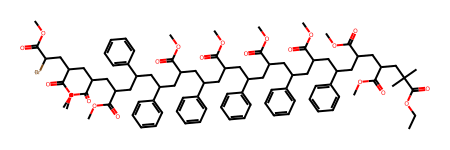

In [3]:
# Visualize the generated molecule
draw_molecule(generative_bigSMILES)

To better understand the composition of our ensemble, let's visualize its generative graph:

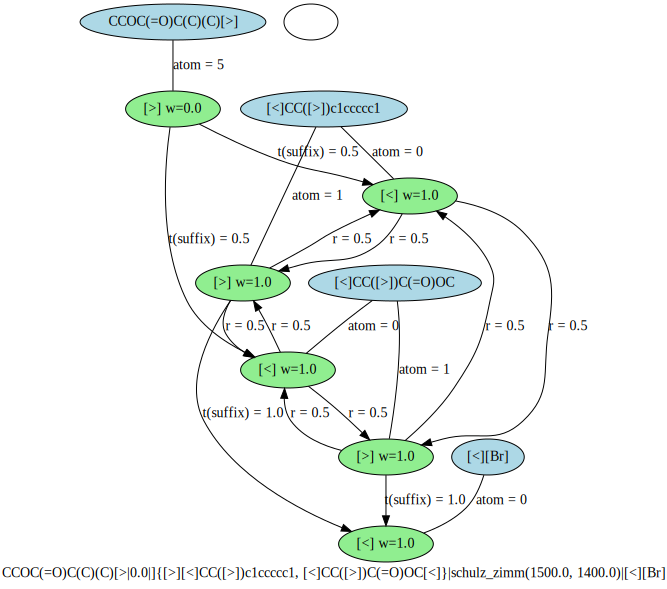

In [4]:
# Draw the generative graph of the ensemble
draw_generation_graph(generative_bigSMILES)

As we can see from both the molecule and its generative graph, Polystyrene (PS) and Poly(methyl methacrylate) (PMMA) are present in equal proportions in this ensemble. Our next step will be to adjust this composition using the bond descriptor weights.

## Creating a PS-r-PMMA ensemble with an 80:20 ratio

We can alter the composition of PS and PMMA by assigning different weights to the bond descriptors.

In [5]:
# Define a generative bigSMILES string with weighted bond descriptors
generative_bigSMILES = "CCOC(=O)C(C)(C){[>][<|8|]CC([>|8|])c1ccccc1, [<|2|]CC([>|2|])C(=O)OC [<]}|schulz_zimm(1500, 1400)|[Br]"

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


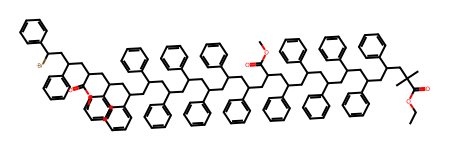

In [6]:
# Visualize the new generated molecule
draw_molecule(generative_bigSMILES)

The changes are noticeable, with PS now being the majority monomer and PMMA reduced to a minority. The generative graph will reflect this change, particularly in the transition rates `r` between bond descriptors for the two monomers.

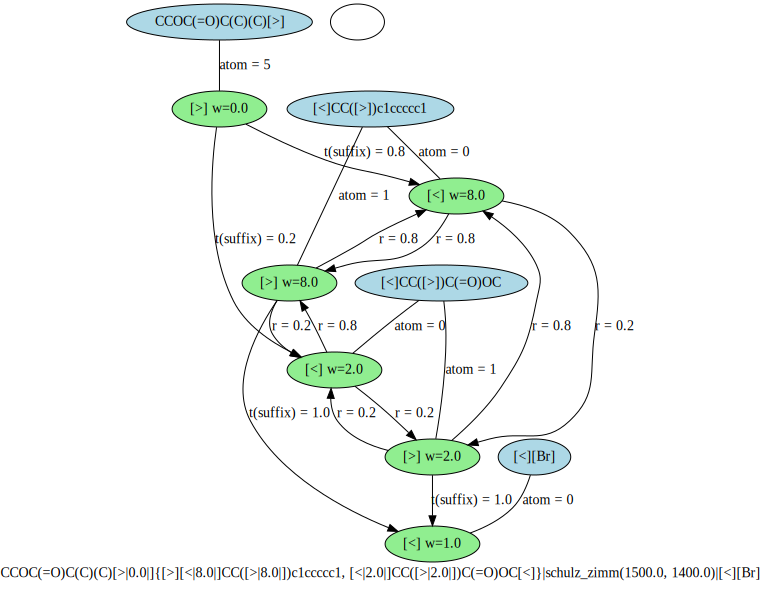

In [7]:
# Draw the generative graph for the modified ensemble
draw_generation_graph(generative_bigSMILES)

## Modifying PS-r-PMMA blockiness to 70% with a 50:50 ratio

In the previous example, we adjusted the ratio of PS to PMMA but didn't specify the blockiness, or the likelihood that a given monomer is followed by the same type. By using list weight notation in our generative bigSMILES string, we can set the transition probabilities for PS to PS and PMMA to PMMA.

For instance, let's set the transition probability for both PS -> PS and PMMA -> PMMA to 70%, yielding a noticeably blockier random copolymer. We can accomplish this by assigning weights of 7 and 3 to the respective transitions between the monomers.

In [8]:
# Define a generative bigSMILES string with adjusted blockiness
generative_bigSMILES = "CCOC(=O)C(C)(C){[>][<|0 7 0 3|]CC([>|7 0 3 0|])c1ccccc1, [<|0 3 0 7|]CC([>|3 0 7 0|])C(=O)OC [<]}|schulz_zimm(1500, 1400)|[Br]"

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


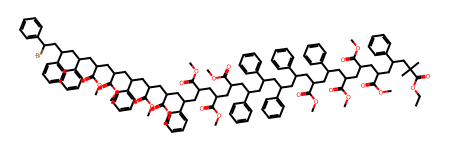

In [9]:
# Visualize the blockier molecule
draw_molecule(generative_bigSMILES)

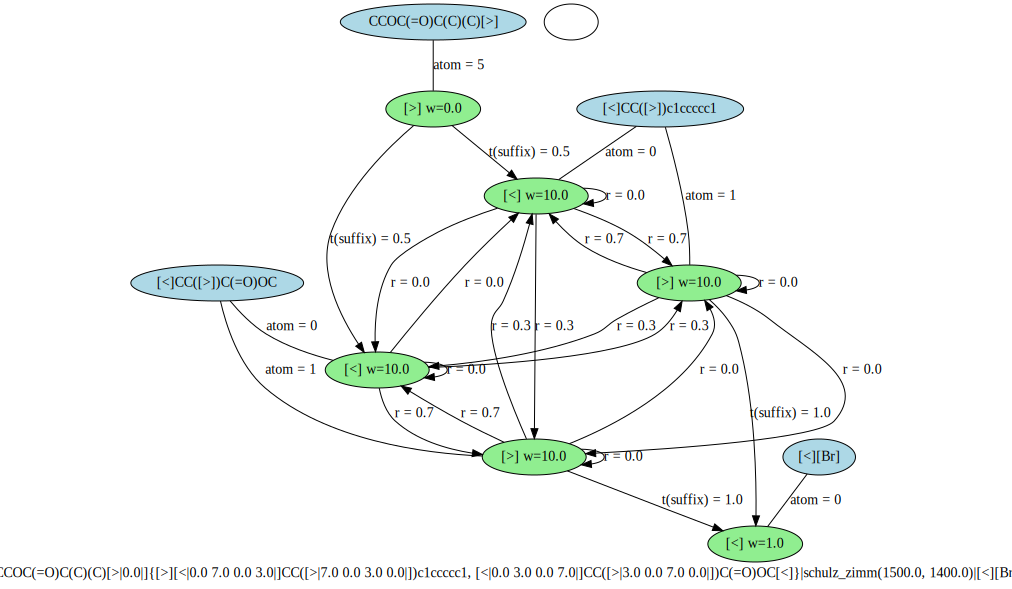

In [10]:
# Draw the generative graph for the blockier ensemble
draw_generation_graph(generative_bigSMILES)

From the generative graph, you can see how the transition probabilities now favor remaining within the same block rather than switching to a new one.

## PS-r-PMMA with 70% blockiness for PS and 20% for PMMA

In the previous example, the transition probability into the other block was 30% for both blocks, resulting in a balanced ratio of 50% between the two monomers. However, we can exert more control over the composition by varying the blockiness of the different blocks.

In this case, we will maintain the 70% blockiness for Polystyrene (PS) but reduce the blockiness of Poly(methyl methacrylate) (PMMA) to 20%.

In [11]:
# Define a generative bigSMILES string with varied blockiness
generative_bigSMILES = "CCOC(=O)C(C)(C){[>][<|0 7 0 3|]CC([>|7 0 3 0|])c1ccccc1, [<|0 8 0 2|]CC([>|8 0 2 0|])C(=O)OC [<]}|schulz_zimm(2500, 2400)|[Br]"

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


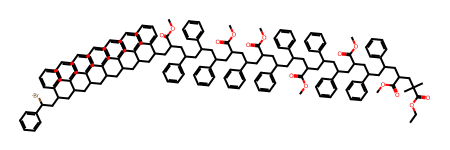

In [12]:
# Visualize the resulting molecule
draw_molecule(generative_bigSMILES)

In the generated molecule, you can see that PS remains blocky, but it is now interspersed with less blocky PMMA monomers. The ratio between the monomers can be estimated by comparing the probabilities to stay within the same block, which yields approximately 0.286.

The generative graph should also accurately represent these transition probabilities.

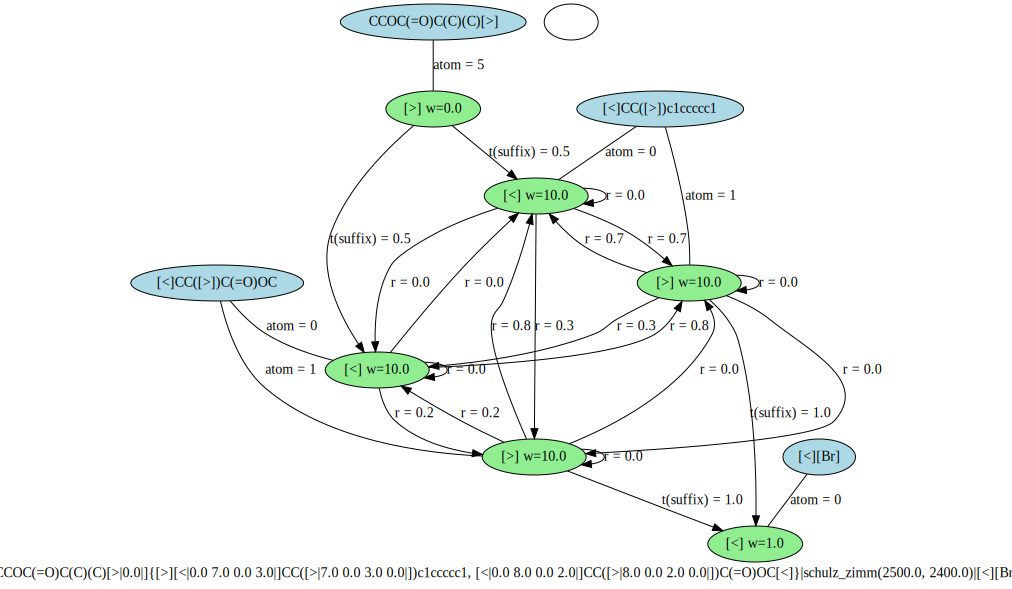

In [13]:
# Draw the generative graph for the modified ensemble
draw_generation_graph(generative_bigSMILES)

## PS-r-PMMA in an alternating sequence (least blocky)

One way to minimize blockiness is by creating an alternating sequence of monomers. This can be represented with identical bond descriptors in the regular BigSMILES notation. For example, the string `CCOC(=O)C(C)(C){[>2][<1]CC([>2])c1ccccc1, [<2]CC([>1])C(=O)OC ; [<1][Br], [<2][Br] []}` specifies that each monomer can only bond with the other monomer type and not with itself, resulting in an alternating sequence.

This limitation is represented by using stochastic end groups with both bond descriptors, as the molecule can end in either PS or PMMA and both need to be terminable. However, this prevents continuation of the molecule after the stochastic object.

To overcome this limitation in generative BigSMILES, we can use listed bond weights instead. This allows all bond descriptors to be compatible while defining zero transition probabilities for unwanted connections.

In [14]:
# Define a generative bigSMILES string with zero transition probabilities for unwanted connections
generative_bigSMILES = "CCOC(=O)C(C)(C){[>][<|0 0 0 1|]CC([>|0 0 1 0|])c1ccccc1, [<|0 1 0 0|]CC([>|1 0 0 0|])C(=O)OC [<]}|schulz_zimm(1000, 900)|[Br]"

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


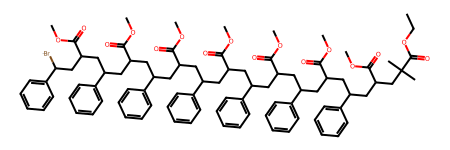

In [15]:
# Visualize the resulting molecule
draw_molecule(generative_bigSMILES)

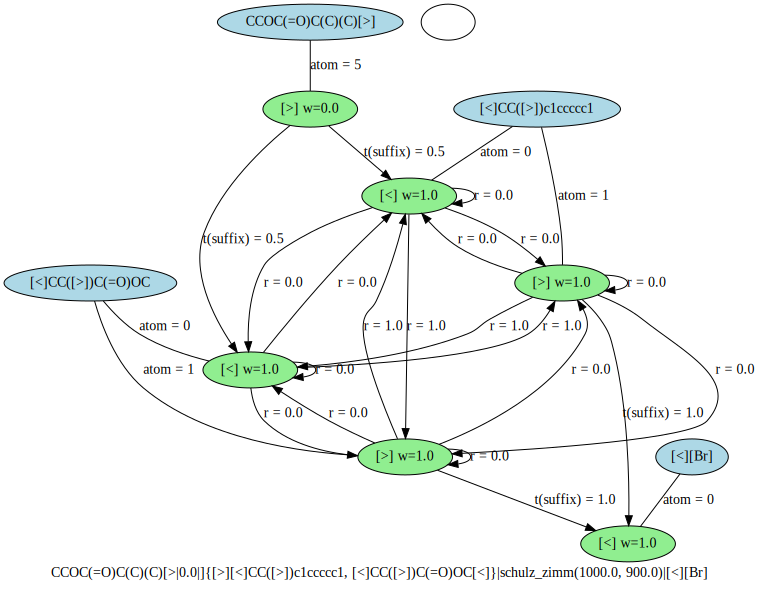

In [16]:
# Draw the generative graph for the alternating ensemble
draw_generation_graph(generative_bigSMILES)

As seen in the generative graph and the generated molecule, the ensemble now follows an alternating sequence. Moreover, the use of listed bond weights allows for potential continuation as it does not require stochastic end groups.

## PS-b-PMMA Diblock Copolymer

At the other end of the spectrum is the diblock copolymer. While the original BigSMILES notation correctly describes diblock copolymers, a more explicit representation employs two connected stochastic objects, as seen in the string `CCOC(=O)C(C)(C){[>][<]CC([>])c1ccccc1 [<]}{[>][<]CC([>])C(=O)OC[<]}[Br]`.

The same notation can be applied within the generative BigSMILES:

In [17]:
# Define a generative bigSMILES string for a diblock copolymer
generative_bigSMILES = "CCOC(=O)C(C)(C){[>][<]CC([>])c1ccccc1 [<]}|schulz_zimm(1000,900)|{[>][<]CC([>])C(=O)OC[<]}|schulz_zimm(1000, 900)|[Br]"

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


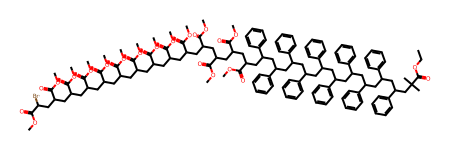

In [18]:
# Visualize the resulting molecule
draw_molecule(generative_bigSMILES)

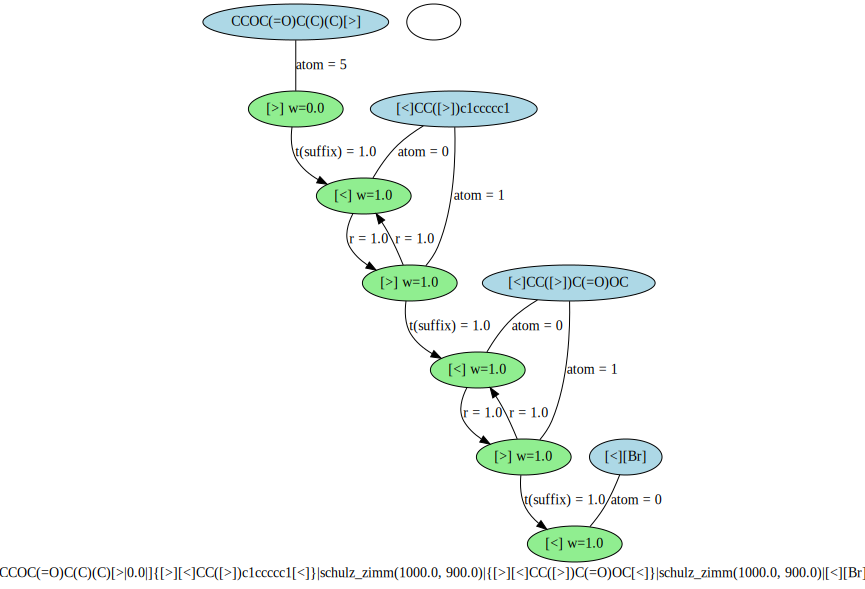

In [19]:
# Draw the generative graph for the diblock copolymer
draw_generation_graph(generative_bigSMILES)

In the BigSMILES notation, the ratio between the two blocks remains unspecified. However, with generative BigSMILES, you can specify the size of the two blocks via the molecular weight specification for each stochastic object.

## PS and PMMA Homopolymer Mixtures

The original BigSMILES notation also encompasses polymer ensembles of PS and PMMA homopolymers, and mixtures of the two, although it's recommended to avoid describing the homopolymers in this way.

There exists a BigSMILES variant that can depict a mixture of PS and PMMA homopolymers:

`{[][<1]CC([>1])c1ccccc1, [<2]CC([>2])C(=O)OC; CC(C)[>1], CC(C)[>2], [<1][Br], [<2][Br][]}`

In this variant, all bond descriptors between PS or PMMA are incompatible, preventing connections between PS and PMMA monomers or end groups. As a result, this notation uniquely identifies a mixture of PS and PMMA homopolymers. However, using this notation to depict a mixture is strongly discouraged.

This characteristic of the notation can be utilized in generative BigSMILES as well:

In [20]:
# Define a generative bigSMILES string for a mixture of PS and PMMA homopolymers
generative_bigSMILES = "{[][<1]CC([>1])c1ccccc1, [<2]CC([>2])C(=O)OC; CC(C)[>1|2|], CC(C)[>2], [<1|2|][Br], [<2][Br][]}|schulz_zimm(700, 600)|"

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


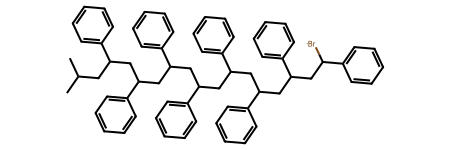

In [21]:
# Visualize the resulting molecules
draw_molecule(generative_bigSMILES)

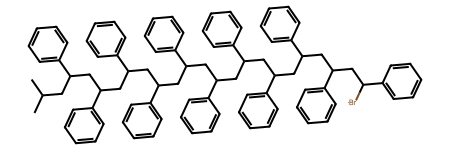

In [22]:
# Visualize the resulting molecules
draw_molecule(generative_bigSMILES)

Note how the various homopolymers are generated from a single BigSMILES string. We've used the weight of the end groups to achieve a 2:1 ratio between PS and PMMA.

The generative graph clearly illustrates how the two types of molecules are separate from one another:

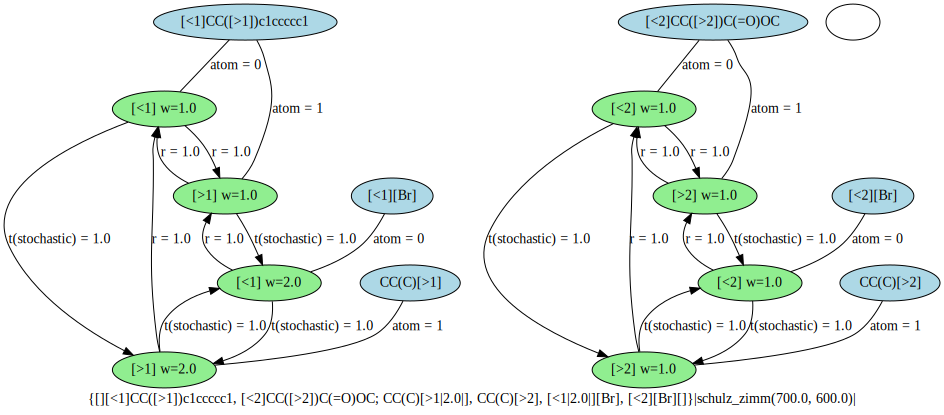

In [23]:
# Draw the generative graph for the mixture of homopolymers
draw_generation_graph(generative_bigSMILES)

Despite this functionality, using this notation

to describe a mixture of homopolymers remains inadvisable. Instead, use the mixture notation of generative BigSMILES, which offers finer control over the resulting ensembles and more accurately conveys the intent:

In [24]:
# Define a generative bigSMILES string for a more explicit mixture of PS and PMMA homopolymers
generative_bigSMILES = "CC(C){[>][<]CC([>])c1ccccc1 [<]}|schulz_zimm(700, 600)|[Br].|5000|CC(C){[>][<]CC([>])C(=O)OC[<]}|schulz_zimm(700, 600)|[Br].|66%|"

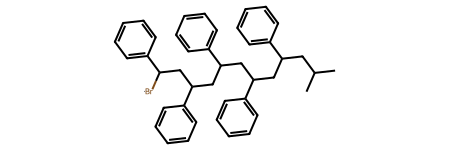

In [25]:
# Visualize the resulting molecules
draw_molecule(generative_bigSMILES)

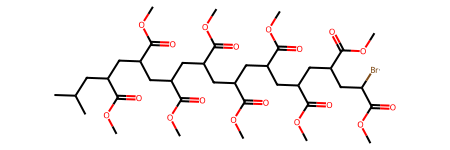

In [26]:
draw_molecule(generative_bigSMILES)

The enhanced notation, strongly recommended for mixtures, leads to the same molecular ensemble but is more straightforward and doesn't necessitate single stochastic object notation for mixtures.

This applies universally to mixtures such as polymers in solution, even though we're showcasing a mixture of two homopolymers here.

## Homopolymer: AA, BB Nylon 6,6

Nylon 6,6 constitutes two alternating repeat units in an AA,BB sequence. This can be effectively represented in BigSMILES using directed bond descriptors `[<], [>]`. Here's the corresponding representation:

`{[][<]C(=O)CCCCC(=O)[<],[>]NCCCCCCN[>];[>]O, [<][H][]}`

The same applies for generative BigSMILES. Once we incorporate a molecular weight distribution for step-growth polymerization, it enables the generation of realistic polymers.

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


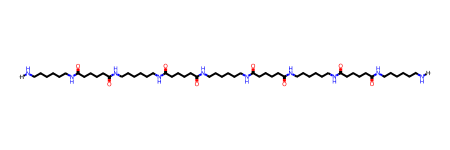

In [27]:
generative_bigSMILES = "{[][<]C(=O)CCCCC(=O)[<],[>]NCCCCCCN[>]; [<][H], [>]O []}|flory_schulz(4e-3)|"
draw_molecule(generative_bigSMILES)

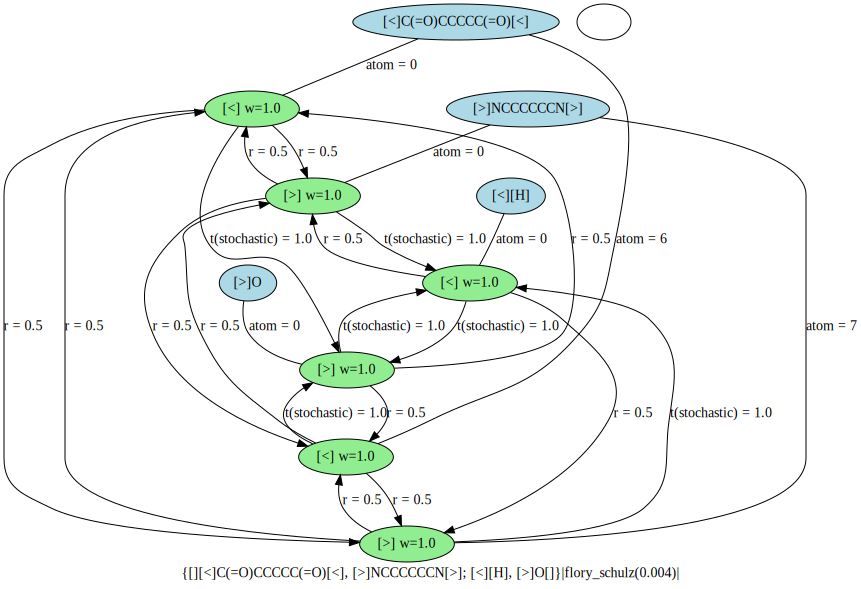

In [28]:
draw_generation_graph(generative_bigSMILES)

This authentic representation of Nylon 6,6 allows the generation to either conclude on an A unit `[<]C(=O)CCCCC(=O)[<]`, which is stochastically terminated with `[>]O`, or a B unit `[>]NCCCCCCN[>]` that ends with `[<][H]`. This is a typical scenario, which becomes evident as we generate more instances of the ensemble. However, to specify the repeat unit with which the generation should end, we need to delve deeper in the next section.

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


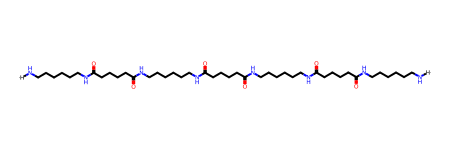

In [29]:
draw_molecule(generative_bigSMILES)

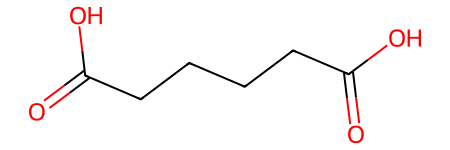

In [30]:
draw_molecule(generative_bigSMILES)

## Terminal Groups

As alluded to earlier, having advanced control over the terminal groups enables the description of diverse molecules. Transitioning from realistic Nylon 6,6 with two distinct stochastic endgroups to polyamide necessitates us to define explicitly the desired end group.

### Explicit: Polyamide

In BigSMILES, polyamide can be described as follows: `[H]O{[>][<]C(=O)CCCCC(=O)[<],[>]NCCCCCCN[>][<]}[H]`. With the appropriate terminal bond descriptor `[<]` oriented towards the left, this molecule must end with the B group `NCCCCCCN`.

A direct translation into generative BigSMILES isn't feasible here, since a stochastic generation could end with an A group. This situation could result in a missing corresponding end group to terminate the generation. Instead, we can define two possible end groups, with one adding a B unit prior to termination.

`[H]O{[>][<]C(=O)CCCCC(=O)[<],[>]NCCCCCCN[>]; [<][H], [>]NCCCCCCN[H] []}`

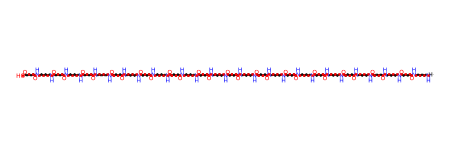

In [31]:
generative_bigSMILES = "O{[>][<]C(=O)CCCCC(=O)[<],[>]NCCCCCCN[>]; [<][H], [>]NCCCCCCN[H] []}|flory_schulz(1e-3)|"
draw_molecule(generative_bigSMILES)

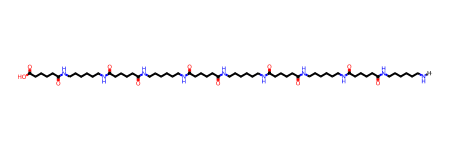

In [32]:
draw_molecule(generative_bigSMILES)

### Mixed

Stochastic end groups can also be applied in a mixed setting, where some sections of a stochastic object are terminated stochastically and others are terminated deterministically.

The bottlebrush from the primary manuscript serves as a perfect example of this scenario. Here, the arms are terminated with a stochastic end group `[H]`, while the backbone concludes with a bromine.

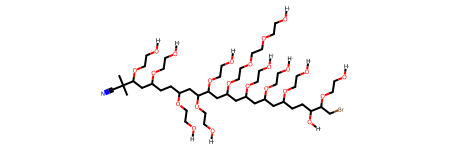

In [33]:
generative_bigSMILES = "N#CC(C)(C){[$] O([<|3|])(C([$])C[$]), [>]CCO[<|0 0 0 1 0 2|] ; [>][H] [$]}|poisson(900)|Br"
draw_molecule(generative_bigSMILES)

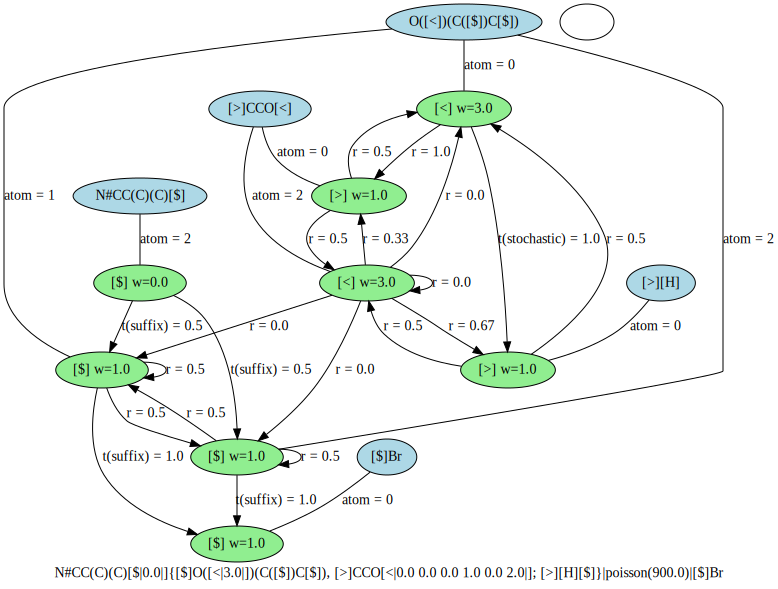

In [34]:
draw_generation_graph(generative_bigSMILES)

## Star Polymers

Star polymers are a unique class of polymers characterized by a central hub from which several arms extend outwards. A BigSMILES representation of a star polymer might look like this:

`OC({[$][$]CC[$][$]}[H])({[$][$]CC[$][$]}[H])({[$][$]CC[$][$]}[H])`

There are various approaches to represent star polymers in generative BigSMILES, which we will explore in the subsequent sections.

### Starting with a Central Hub to Grow Arms

A suitable starting point for generative BigSMILES of star polymers is the central connection point for the arms. In the given example, I am using a 3-arm polymer, so the central connecting element may appear as: `C(C[<])(C[<])(C[<])`. The three arms of the polymer can sprout from the three `[<]` bond descriptors.

We use a trick to ensure that the generation begins with this element by separating one atom (in this case `[H]`) from the initial carbon of the stochastic element and placing it as the prefix:

`[H]{[$] [$]C(C[<])(C[<])(C[<]) ...`

Here, the `[$]` bond descriptor is the right terminal bond descriptor and is only compatible with our initial central element.

#### Equal Length Arms

Next, we append the growth repeat units for the arms and add the terminal group for the arms to the stochastic element, ensuring each is only compatible with the other.

`[H]{[$] [$]C(C[<])(C[<])(C[<]), [>]CC[<]; [>][H] []}`

Now, we just need to add a molecular weight distribution. This distribution encompasses the length of the combined arms as they grow stochastically. The Gaussian distribution is a good fit for this task due to its linearity. By adding up the means and variances of the separate arms, we can achieve a Gaussian distribution for them. For example, let's assume we desire arms with an Mw of 200 and a variance of 50. Note that the arm length growth is entirely stochastic in this case.

`[H]{[$] [$]C(C[<])(C[<])(C[<]), [>]CC[<]; [>][H] []}|gauss(600, 150)|`

In [35]:
generative_bigSMILES = "[H]{[$] [$]C(C[<])(C[<])(C[<]), [>]CC[<]; [>][H] []}|gauss(600, 150)|"

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


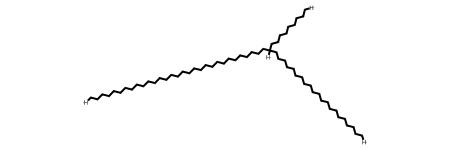

In [36]:
draw_molecule(generative_bigSMILES)

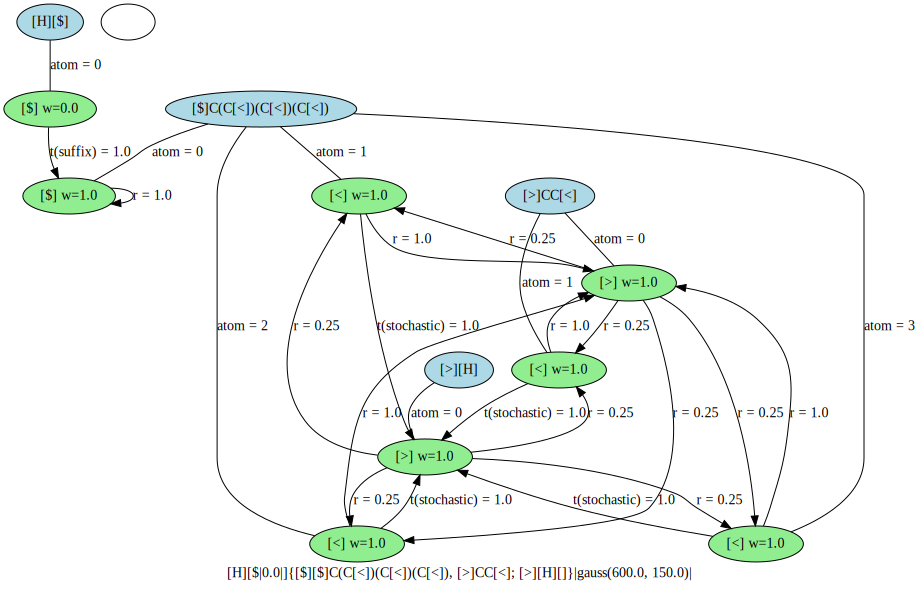

In [37]:
draw_generation_graph(generative_bigSMILES)

#### Non-equal Length Arms

In the case where the arms are not of equal length, we can describe this similarly to random copolymers by assigning different weights to different growth repeat units.

`[H]{[$] [$]C(C[<])(C[<])(C[<2]), [>]CC[<], [>2]CCO[<2]; [>][H], [>2][Si](C)(C)C []}|gauss(600, 150)|`

Here we utilize the third attachment point to affix a separate arm with a unique chemistry `[>2]OCO[<2]` and a unique end group for it `[>2]O`. It is noteworthy that it isn't necessary to have separate chemistries here, just different bond descriptors suffice.

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


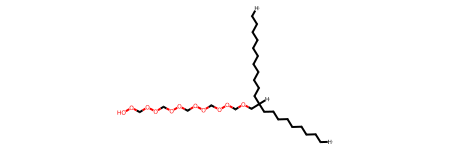

In [38]:
generative_bigSMILES = "[H]{[$][$]C(C[<])(C[<])(C[<2]), [>]CC[<], [>2]OCO[<2]; [>][H], [>2]O []}|gauss(600, 150)|"
draw_molecule(generative_bigSMILES)

Next, we can assign different weights to this special arm, making it shorter or longer relative to the other arms. Here we increase the weight from the default `|1|` to `|2|`, thus making it twice as likely to grow the second arm.

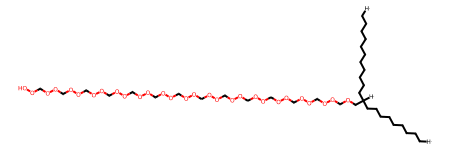

In [39]:
generative_bigSMILES = "[H]{[$] [$]C(C[<])(C[<])(C[<2|2|]), [>]CC[<], [>2|2|]OCO[<2|2|]; [>][H], [>2]O []}|gauss(800, 200)|"
draw_molecule(generative_bigSMILES)

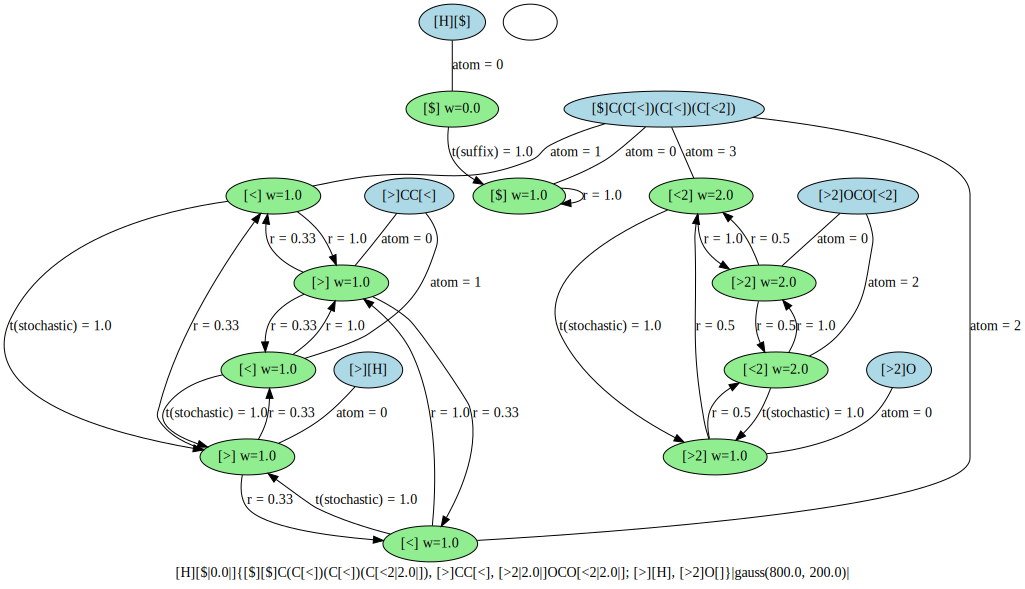

In [40]:
draw_generation_graph(generative_bigSMILES)

### Regulating Arm Molecular Weight

There may be situations where it's necessary to control the molecular weight of each individual arm in a polymer. While this can be accomplished with nested stochastic objects, such functionality isn't supported by this reference implementation. Nevertheless, generative BigSMILES can still perform this task as long as the arms originate from separate atoms.

Consider the following BigSMILES example, where each stochastic object describes a separate arm:

`C{[$] [$]C(CC[<])C[$], [>]CC[<]; [>][H] [$]}CC{[$] [$]C(CC[<])C[$], [>]CC[<]; [>][H] [$]}CC{[$] [$]C(CC[<])C[$], [>]CC[<]; [>][H] [$]}[H]`

To ensure smooth generation with generative BigSMILES, we need to make a few modifications:

1. We assign a molecular weight distribution to each stochastic object, representing an arm.
2. The bond descriptors connecting the arms (and stochastic objects) are distinct from the arms, denoted here by [$] and [>].
3. These bond descriptors are also assigned zero weight, preventing the element from being repeated and ensuring only one arm per stochastic element.
4. We illustrate two variations to achieve this; both work equally well.
5. Finally, we ensure that terminal bond descriptors propagate to the next arm stochastic element.

This approach allows for the independent control of the molecular weight of each arm.

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


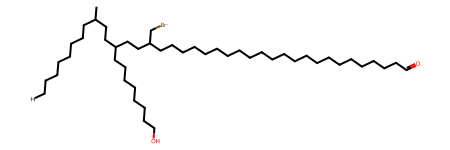

In [41]:
generative_bigSMILES = "C{[$] [$]C(CC[<])C[$2|0|], [>]CC[<]; [>][H] [$2]}|uniform(100,101)|"
generative_bigSMILES += "C{[$] [$]C(CC[<])C[$2|0|], [>]CC[<]; [>]O [$2]}|schulz_zimm(200,150)|"
generative_bigSMILES += "C{[$] [$|0|]C(CC[<])C[$|0|], [>]CC[<]; [>]C(=O) [$]}|gauss(300,30)|[Br]"

draw_molecule(generative_bigSMILES)

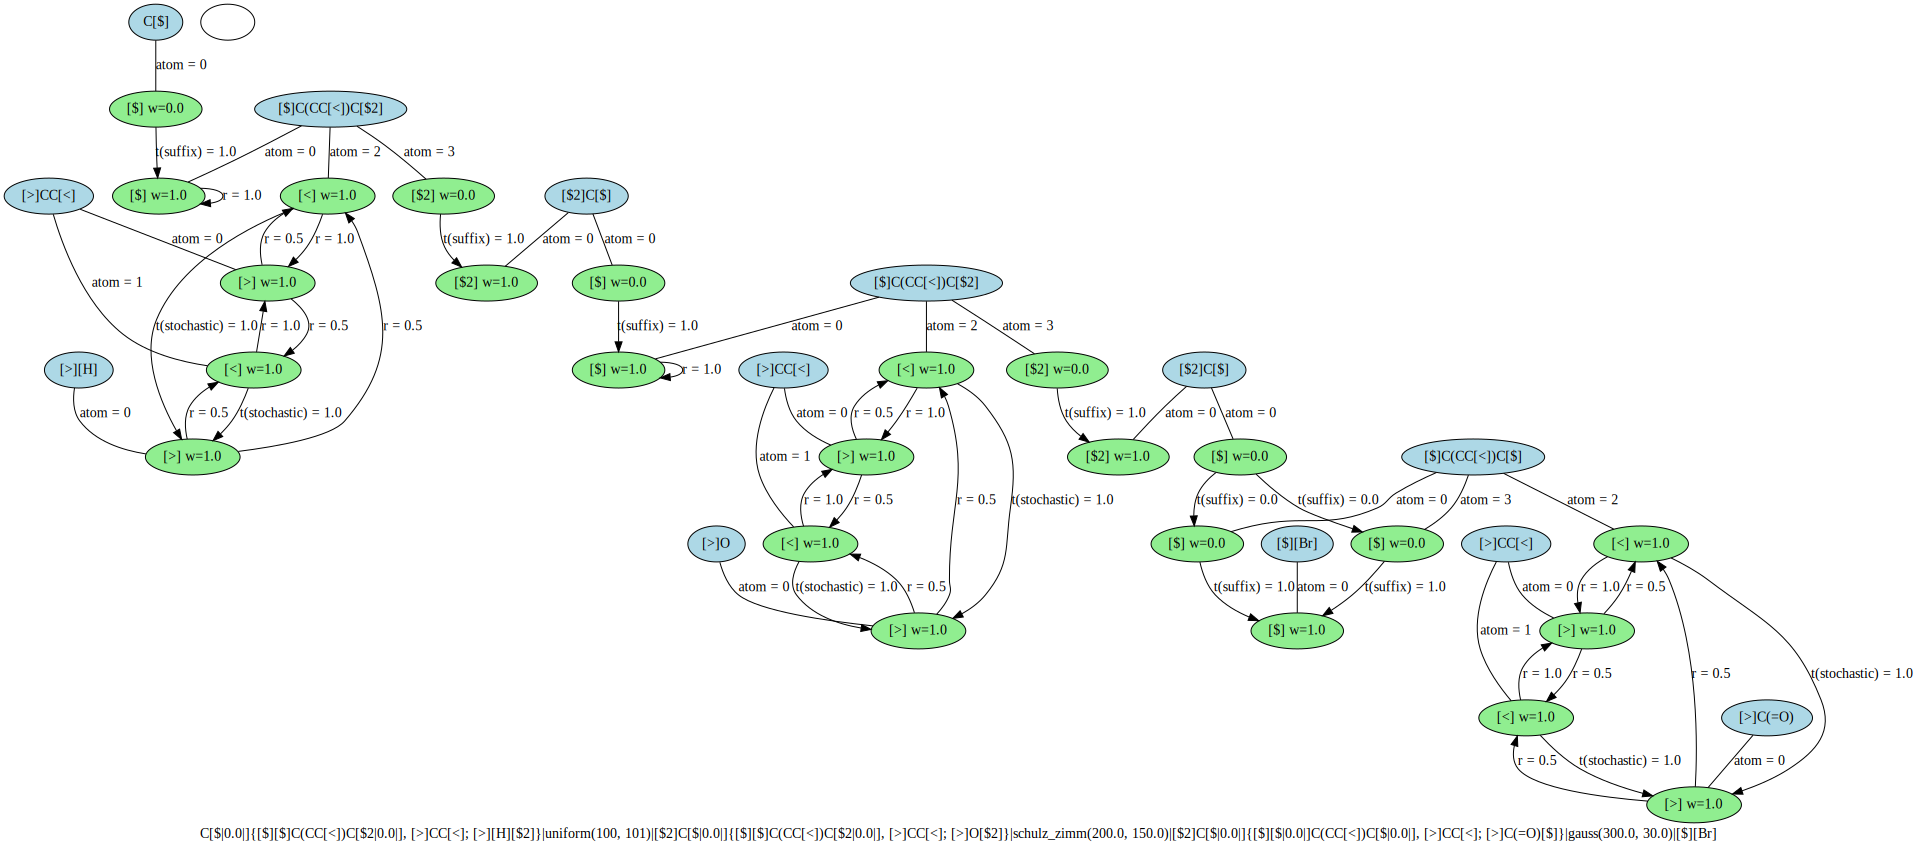

In [42]:
draw_generation_graph(generative_bigSMILES)

## Ring Polymer

A stochastic ring polymer can be represented in BigSMILES using connection notation `1` across a stochastic object, like so: `C1{[>][<]CCO[>][<]}CO1`. Here, the first carbon atom and the last oxygen atom complete the ring with a covalent bond, each labeled with `1`.

This can be replicated in generative BigSMILES: `C1{[>][<]CCO[>][<]}|poisson(1000)|CO1`. However, the current reference implementation doesn't support connection across a stochastic object.

_Note_: The reasoning behind this lack of support is that every SMILES token must be a valid SMILES string for a molecule. Neither the prefix `C1` nor the suffix `CO1` are valid SMILES strings for molecule generation.


## Hyper-Branched Polymer: Poly-Ethylene

The BigSMILES for branched poly-ethylene can be defined as: `C{[$][$]CC([$])[$],[$]CC[$]; [$][H][$]}[H]`.

Generative BigSMILES provides more control. Firstly, a molecular weight distribution, Flory-Schulz in this case, is added:

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


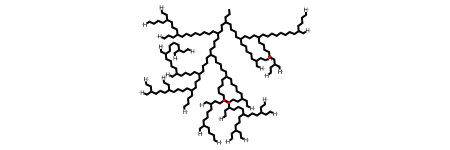

In [43]:
generative_bigSMILES = "C{[$][$]CC(CC[$])(CC[$]),[$]CC[$]; [$][H][$]}|flory_schulz(1e-3)|[H]"
draw_molecule(generative_bigSMILES)

Furthermore, the branch point density can be stochastically controlled via the weights of bond descriptors. In this example, all bond descriptors in a branch point repeat unit are assigned a weight of 1/10. The resulting transition probabilities can be interpreted from the generation graph:

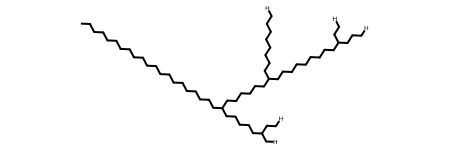

In [44]:
generative_bigSMILES = "C{[$][$|.1|]CC(CC[$|.1|])(CC[$|.1|]),[$]CC[$]; [$][H][$]}|flory_schulz(5e-3)|[H]"
draw_molecule(generative_bigSMILES)

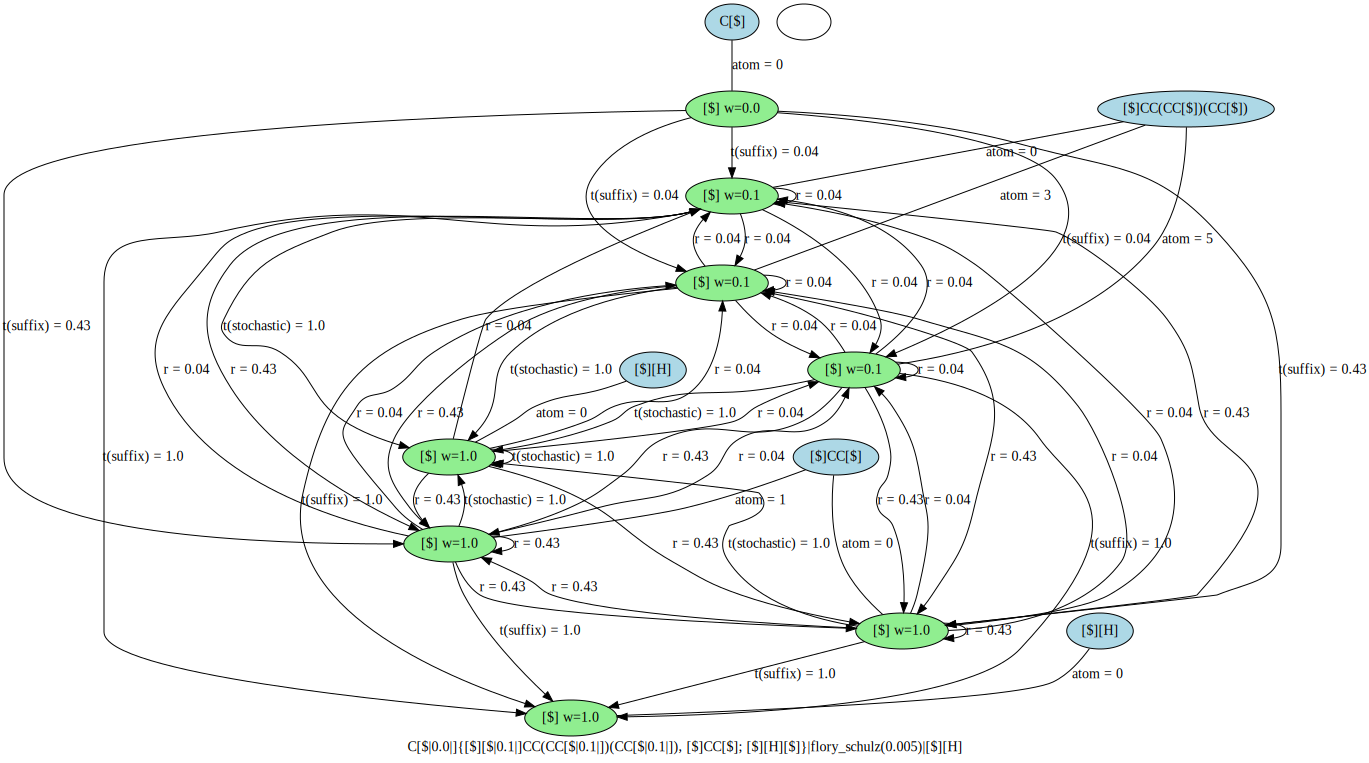

In [45]:
draw_generation_graph(generative_bigSMILES)

## Excluding Internal Loops: Low-Density Polyethylene

Low-density polyethylene can form loops during synthesis. That is, high branching can lead to rings within a single molecule. However, Generative BigSMILES currently doesn't support this. Like cross-linked networks, we believe that spatial considerations should be incorporated into molecule generation, a function beyond the capacity of line notations. In the future, we might consider an extension to the Generative BigSMILES notation to cover this situation. For now, if a polymer ensemble is more restrictively defined with Generative BigSMILES, molecules with loops are always excluded.